In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycatch22

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

In [28]:
############################
# 1) DATA LOADING & MERGING
############################

def convert_spared_to_label(val):
    """
    Convert 'spared' to binary: 0 if spared (TRUE), 1 if resected (FALSE).
    """
    if isinstance(val, bool):
        return 0 if val else 1
    elif isinstance(val, str):
        return 0 if val.strip().upper() == 'TRUE' else 1
    else:
        return 0 if bool(val) else 1

def load_all_subjects(subjects_dir, subject_list):
    """
    Loads each subject's aggregated pickle (sub-XXXX_features_averaged.pkl),
    adds a 'subject_id' column, and concatenates into one DataFrame.
    """
    all_dfs = []
    for subj in subject_list:
        subj_path = os.path.join(subjects_dir, subj)
        pkl_file = os.path.join(subj_path, f"{subj}_features_averaged.pkl")
        if not os.path.isfile(pkl_file):
            print(f"Warning: file not found: {pkl_file}")
            continue
        df = pd.read_pickle(pkl_file)
        df['subject_id'] = subj
        if 'spared' not in df.columns:
            raise ValueError(f"'spared' column missing for {subj}")
        df['label'] = df['spared'].apply(convert_spared_to_label)
        all_dfs.append(df)
    if not all_dfs:
        raise ValueError("No data loaded. Check paths or subject list.")
    combined_df = pd.concat(all_dfs, axis=0, ignore_index=True)
    return combined_df

In [29]:
######################
# 2) PREPROCESSING
######################

# dvakrat meraj raz rez
def get_explicit_feature_list():
    # Bandpower features for each band
    band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    band_features = [f"{band}_{metric}" for band in band_names for metric in ['power', 'rel', 'log']]
    
    # FOOOF features.
    fooof_features = [
        'fooof_aperiodic_offset', 
        'fooof_aperiodic_exponent', 
        'fooof_r_squared', 
        'fooof_error', 
        'fooof_num_peaks'
    ]
    
    # Entropy feature.
    entropy_features = ['entropy_5secwin']
    
    # Obtain catch22 feature names via a dummy call.
    dummy = np.random.randn(100).tolist()
    res = pycatch22.catch22_all(dummy, catch24=False)
    catch22_features = [f"catch22_{nm}" for nm in res['names']]
    
    return band_features + fooof_features + entropy_features + catch22_features

# def get_feature_list(df):
#     """
#     Returns a list of feature columns to use.
#     We ignore metadata columns like 'label', 'subject_id', and 'spared'.
#     """
#     ignore_cols = {'label', 'subject_id', 'spared'}
#     feature_cols = [col for col in df.columns 
#                     if col not in ignore_cols and pd.api.types.is_numeric_dtype(df[col])]
#     return feature_cols

In [30]:
######################
# 3) MODEL TRAINING & EVALUATION
######################

# runs on subjects (not electrodes)
def train_and_evaluate_with_groups(X, y, groups, model_choice='random_forest'):
    if model_choice == 'random_forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_choice == 'logistic':
        model = LogisticRegression(max_iter=1000, random_state=42)
    elif model_choice == 'svm':
        model = SVC(kernel='rbf', probability=True, random_state=42)
    else:
        raise ValueError("model_choice must be one of ['random_forest','logistic','svm']")
    
    gkf = GroupKFold(n_splits=5)
    accuracies, aucs = [], []
    for train_idx, val_idx in gkf.split(X, y, groups=groups):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        acc = accuracy_score(y_val_cv, y_pred_cv)
        accuracies.append(acc)
        if hasattr(model, 'predict_proba'):
            y_proba_cv = model.predict_proba(X_val_cv)[:, 1]
            aucs.append(roc_auc_score(y_val_cv, y_proba_cv))
    
    print(f"\n=== {model_choice.upper()} GROUP-CV Results ===")
    print(f"Accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
    if aucs:
        print(f"ROC AUC:  {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    
    # Fit on full training data
    model.fit(X, y)
    return model

# def train_and_evaluate(X, y, model_choice='random_forest'):
#     """
#     Trains a model with 5-fold cross-validation on (X, y) and returns the fitted model.
#     Prints mean accuracy and ROC AUC across folds.
#     """
#     if model_choice == 'random_forest':
#         model = RandomForestClassifier(n_estimators=100, random_state=42)
#     elif model_choice == 'logistic':
#         model = LogisticRegression(max_iter=1000, random_state=42)
#     elif model_choice == 'svm':
#         model = SVC(kernel='rbf', probability=True, random_state=42)
#     else:
#         raise ValueError("model_choice must be one of ['random_forest','logistic','svm']")
    
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     accuracies, aucs = [], []
#     for train_idx, val_idx in skf.split(X, y):
#         X_train_cv, X_val_cv = X[train_idx], X[val_idx]
#         y_train_cv, y_val_cv = y[train_idx], y[val_idx]
#         model.fit(X_train_cv, y_train_cv)
#         y_pred_cv = model.predict(X_val_cv)
#         acc = accuracy_score(y_val_cv, y_pred_cv)
#         accuracies.append(acc)
#         if hasattr(model, 'predict_proba'):
#             y_proba_cv = model.predict_proba(X_val_cv)[:, 1]
#             aucs.append(roc_auc_score(y_val_cv, y_proba_cv))
    
#     print(f"\n=== {model_choice.upper()} CROSS-VALIDATION ===")
#     print(f"Accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
#     if aucs:
#         print(f"ROC AUC:  {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    
#     # Fit on full training data
#     model.fit(X, y)
#     return model

In [31]:
######################
# 4) PIPELINE
######################

# Adjust these paths and subject list to match your setup.
subjects_dir = "/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean"
subject_list = [
    "sub-RID0031", "sub-RID0032", "sub-RID0033", "sub-RID0050", "sub-RID0051", 
    "sub-RID0064", "sub-RID0089", "sub-RID0101", "sub-RID0117", "sub-RID0143",
    "sub-RID0167", "sub-RID0175", "sub-RID0179", "sub-RID0238", "sub-RID0301",
    "sub-RID0320", "sub-RID0381", "sub-RID0405", "sub-RID0424", "sub-RID0508",
    "sub-RID0562", "sub-RID0589", "sub-RID0658"
]

print("Loading data from all subjects...")
combined_df = load_all_subjects(subjects_dir, subject_list)
print(f"Combined data shape: {combined_df.shape}")

# Use the explicit feature list from the extraction script
explicit_feature_list = get_explicit_feature_list()
# Only include features that are present in the combined DataFrame
present_features = [feat for feat in explicit_feature_list if feat in combined_df.columns]
print(f"Using explicit feature list with {len(present_features)} features.")

# Identify feature columns - prev without explicit feature list
# feature_cols = get_feature_list(combined_df)
# print(f"Found {len(feature_cols)} feature columns.")

# Drop rows with missing feature values using the explicit feature list
combined_df = combined_df.dropna(subset=present_features)
X_full = combined_df[present_features].values
y_full = combined_df['label'].values

# # Drop rows with missing feature values
# combined_df = combined_df.dropna(subset=feature_cols)
# X_full = combined_df[feature_cols].values
# y_full = combined_df['label'].values

Loading data from all subjects...
Combined data shape: (1675, 51)
Using explicit feature list with 43 features.


In [32]:
#############################
# 5) TRAIN-TEST SPLIT (80/20) AT SUBJECT LEVEL
#############################

# Get the unique subject IDs
unique_subjects = combined_df['subject_id'].unique()
print("Total unique subjects:", len(unique_subjects))
print("Unique subjects:", unique_subjects)

# Split subjects into training and testing sets (80/20 split)
train_subjects, test_subjects = train_test_split(unique_subjects, test_size=0.2, random_state=42)
print("Number of training subjects:", len(train_subjects))
print("Training subjects:", train_subjects)
print("Number of testing subjects:", len(test_subjects))
print("Testing subjects:", test_subjects)

# Create masks to select rows for train and test based on subject_id
train_mask = combined_df['subject_id'].isin(train_subjects)
test_mask = combined_df['subject_id'].isin(test_subjects)

# Use the explicit feature list variable 'present_features'
X_train = combined_df[train_mask][present_features].values
y_train = combined_df[train_mask]['label'].values

X_test = combined_df[test_mask][present_features].values
y_test = combined_df[test_mask]['label'].values

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Standardize features based on the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Here, we perform a random 80/20 split at the electrode level.
# X_train, X_test, y_train, y_test = train_test_split(
#     X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
# )

# # Standardize features based on the training set
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Total unique subjects: 23
Unique subjects: ['sub-RID0031' 'sub-RID0032' 'sub-RID0033' 'sub-RID0050' 'sub-RID0051'
 'sub-RID0064' 'sub-RID0089' 'sub-RID0101' 'sub-RID0117' 'sub-RID0143'
 'sub-RID0167' 'sub-RID0175' 'sub-RID0179' 'sub-RID0238' 'sub-RID0301'
 'sub-RID0320' 'sub-RID0381' 'sub-RID0405' 'sub-RID0424' 'sub-RID0508'
 'sub-RID0562' 'sub-RID0589' 'sub-RID0658']
Number of training subjects: 18
Training subjects: ['sub-RID0179' 'sub-RID0032' 'sub-RID0238' 'sub-RID0064' 'sub-RID0033'
 'sub-RID0175' 'sub-RID0562' 'sub-RID0050' 'sub-RID0051' 'sub-RID0424'
 'sub-RID0381' 'sub-RID0589' 'sub-RID0658' 'sub-RID0101' 'sub-RID0167'
 'sub-RID0301' 'sub-RID0508' 'sub-RID0089']
Number of testing subjects: 5
Testing subjects: ['sub-RID0320' 'sub-RID0143' 'sub-RID0031' 'sub-RID0117' 'sub-RID0405']
Training set shape: (1251, 43)
Test set shape: (424, 43)



Training Model: RANDOM_FOREST

=== RANDOM_FOREST GROUP-CV Results ===
Accuracy: 0.853 ± 0.055
ROC AUC:  0.620 ± 0.094

--- RANDOM_FOREST TEST SET PERFORMANCE ---
Accuracy: 0.8325471698113207
ROC AUC: 0.5808362925427921

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       353
           1       0.00      0.00      0.00        71

    accuracy                           0.83       424
   macro avg       0.42      0.50      0.45       424
weighted avg       0.69      0.83      0.76       424



/Users/tereza/anaconda3/envs/cnt_gen/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tereza/anaconda3/envs/cnt_gen/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tereza/anaconda3/envs/cnt_gen/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

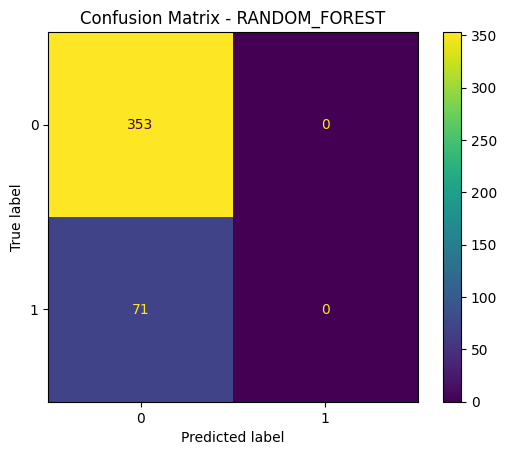


Training Model: LOGISTIC

=== LOGISTIC GROUP-CV Results ===
Accuracy: 0.844 ± 0.056
ROC AUC:  0.595 ± 0.165

--- LOGISTIC TEST SET PERFORMANCE ---
Accuracy: 0.8254716981132075
ROC AUC: 0.6723057894106852

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       353
           1       0.41      0.10      0.16        71

    accuracy                           0.83       424
   macro avg       0.63      0.54      0.53       424
weighted avg       0.77      0.83      0.78       424



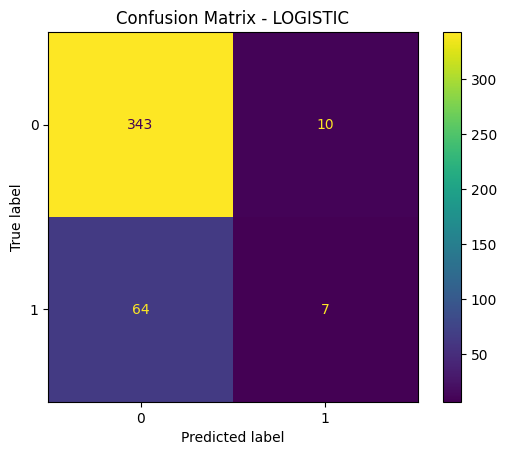


Training Model: SVM

=== SVM GROUP-CV Results ===
Accuracy: 0.858 ± 0.054
ROC AUC:  0.601 ± 0.154

--- SVM TEST SET PERFORMANCE ---
Accuracy: 0.8325471698113207
ROC AUC: 0.6105414355823324

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       353
           1       0.00      0.00      0.00        71

    accuracy                           0.83       424
   macro avg       0.42      0.50      0.45       424
weighted avg       0.69      0.83      0.76       424



/Users/tereza/anaconda3/envs/cnt_gen/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tereza/anaconda3/envs/cnt_gen/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tereza/anaconda3/envs/cnt_gen/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

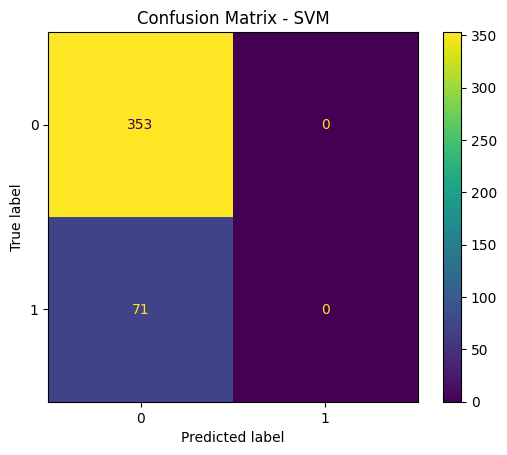

In [33]:
#############################
# 6) TRAIN 3 MODELS & EVALUATE
#############################

models_to_run = ['random_forest', 'logistic', 'svm']
trained_models = {}

for model_name in models_to_run:
    print("\n=======================================")
    print(f"Training Model: {model_name.upper()}")
    
    # Create the group vector for training (subject IDs corresponding to each electrode)
    train_groups = combined_df[train_mask]['subject_id'].values
    
    # Train the model using group-aware cross-validation
    clf = train_and_evaluate_with_groups(X_train_scaled, y_train, groups=train_groups, model_choice=model_name)
    
    # Evaluate on test set
    y_pred_test = clf.predict(X_test_scaled)
    print(f"\n--- {model_name.upper()} TEST SET PERFORMANCE ---")
    print("Accuracy:", accuracy_score(y_test, y_pred_test))
    if hasattr(clf, 'predict_proba'):
        y_proba_test = clf.predict_proba(X_test_scaled)[:, 1]
        print("ROC AUC:", roc_auc_score(y_test, y_proba_test))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))
    
    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format='d')
    plt.title(f"Confusion Matrix - {model_name.upper()}")
    plt.show()
    
    trained_models[model_name] = clf

# for model_name in models_to_run:
#     print("\n=======================================")
#     print(f"Training Model: {model_name.upper()}")
#     clf = train_and_evaluate(X_train_scaled, y_train, model_choice=model_name)
    
#     # Evaluate on test set
#     y_pred_test = clf.predict(X_test_scaled)
#     print(f"\n--- {model_name.upper()} TEST SET PERFORMANCE ---")
#     print("Accuracy:", accuracy_score(y_test, y_pred_test))
#     if hasattr(clf, 'predict_proba'):
#         y_proba_test = clf.predict_proba(X_test_scaled)[:, 1]
#         print("ROC AUC:", roc_auc_score(y_test, y_proba_test))
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred_test))
    
#     # Display confusion matrix
#     cm = confusion_matrix(y_test, y_pred_test)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot(values_format='d')
#     plt.title(f"Confusion Matrix - {model_name.upper()}")
#     plt.show()
    
#     trained_models[model_name] = clf


=== FEATURE IMPORTANCE ASSESSMENT ===


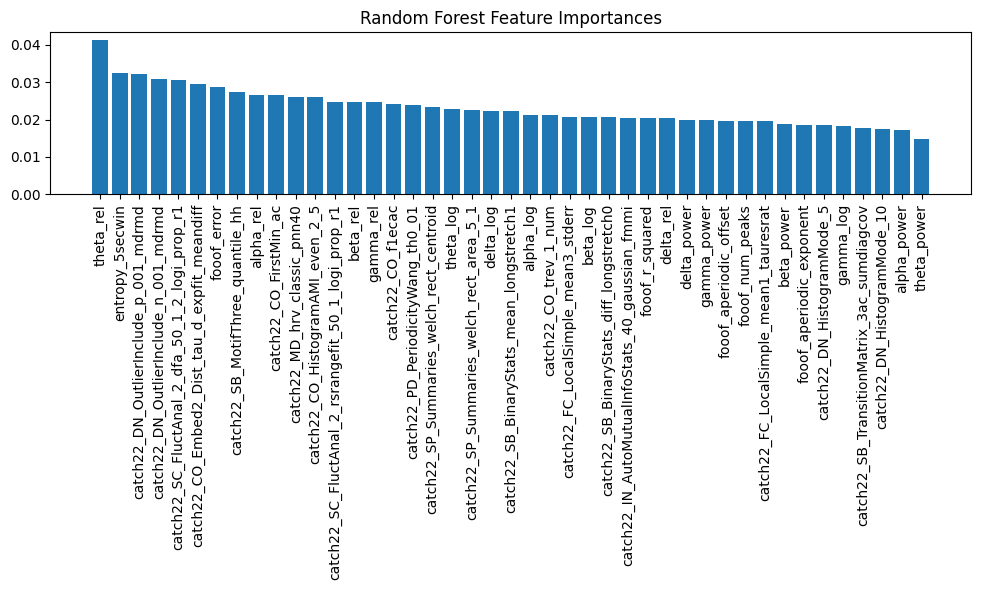

Top 10 RF Features:
1. theta_rel (importance=0.0413)
2. entropy_5secwin (importance=0.0325)
3. catch22_DN_OutlierInclude_p_001_mdrmd (importance=0.0323)
4. catch22_DN_OutlierInclude_n_001_mdrmd (importance=0.0310)
5. catch22_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 (importance=0.0306)
6. catch22_CO_Embed2_Dist_tau_d_expfit_meandiff (importance=0.0297)
7. fooof_error (importance=0.0288)
8. catch22_SB_MotifThree_quantile_hh (importance=0.0273)
9. alpha_rel (importance=0.0267)
10. catch22_CO_FirstMin_ac (importance=0.0265)

Permutation Importance for Logistic Regression (Test Set):


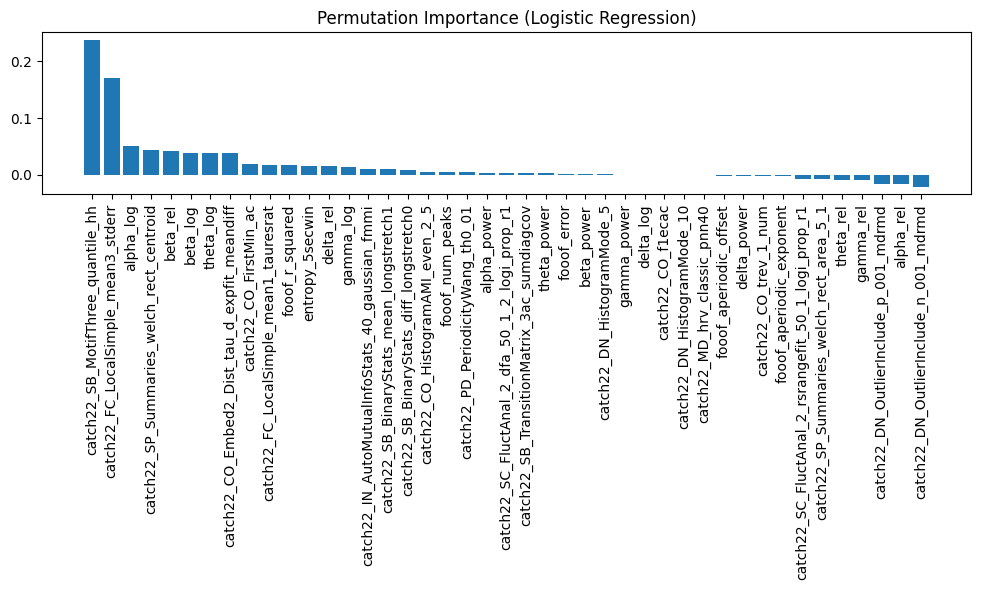


Permutation Importance for SVM (Test Set):


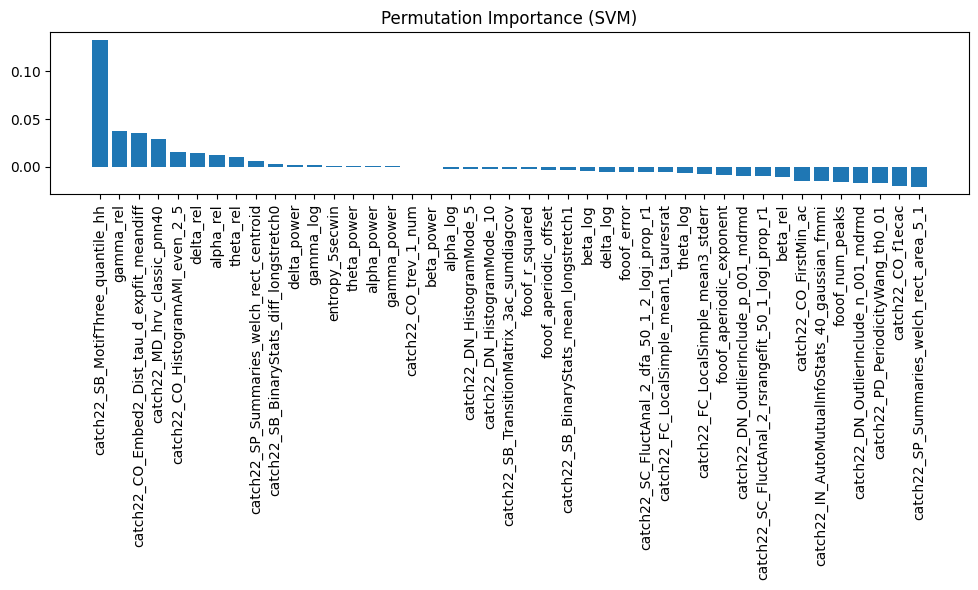

In [34]:
#############################
# 7) FEATURE IMPORTANCE ASSESSMENT
#############################

print("\n=== FEATURE IMPORTANCE ASSESSMENT ===")

# (a) Random Forest built-in importances
rf_model = trained_models.get('random_forest')
if rf_model is not None and hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [present_features[i] for i in sorted_idx]
    plt.figure(figsize=(10,6))
    plt.bar(range(len(importances)), importances[sorted_idx], align='center')
    plt.xticks(range(len(importances)), sorted_features, rotation=90)
    plt.title("Random Forest Feature Importances")
    plt.tight_layout()
    plt.show()
    print("Top 10 RF Features:")
    for i in range(min(10, len(sorted_features))):
        print(f"{i+1}. {sorted_features[i]} (importance={importances[sorted_idx][i]:.4f})")

# (b) Permutation Importance for Logistic Regression
lr_model = trained_models.get('logistic')
if lr_model is not None:
    print("\nPermutation Importance for Logistic Regression (Test Set):")
    result = permutation_importance(
        lr_model, X_test_scaled, y_test, n_repeats=20, random_state=42, scoring='roc_auc'
    )
    perm_importances = result.importances_mean
    sorted_idx = np.argsort(perm_importances)[::-1]
    sorted_features = [present_features[i] for i in sorted_idx]
    plt.figure(figsize=(10,6))
    plt.bar(range(len(perm_importances)), perm_importances[sorted_idx], align='center')
    plt.xticks(range(len(perm_importances)), sorted_features, rotation=90)
    plt.title("Permutation Importance (Logistic Regression)")
    plt.tight_layout()
    plt.show()

# (c) Permutation Importance for SVM (since SHAP is avoided)
svm_model = trained_models.get('svm')
if svm_model is not None:
    print("\nPermutation Importance for SVM (Test Set):")
    result = permutation_importance(
        svm_model, X_test_scaled, y_test, n_repeats=20, random_state=42, scoring='roc_auc'
    )
    perm_importances = result.importances_mean
    sorted_idx = np.argsort(perm_importances)[::-1]
    sorted_features = [present_features[i] for i in sorted_idx]
    plt.figure(figsize=(10,6))
    plt.bar(range(len(perm_importances)), perm_importances[sorted_idx], align='center')
    plt.xticks(range(len(perm_importances)), sorted_features, rotation=90)
    plt.title("Permutation Importance (SVM)")
    plt.tight_layout()
    plt.show()


In [37]:
# %% [code]
print("=== Detailed Summary of Model Results on Test Set ===")

# Loop over each trained model and compute metrics
for model_name in models_to_run:
    print("\n------------------------------")
    print(f"Model: {model_name.upper()}")
    
    model = trained_models[model_name]
    y_pred = model.predict(X_test_scaled)
    
    # Compute ROC AUC if the model supports predict_proba
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = "N/A"
    
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print metrics and classification report; set zero_division=0 to avoid warnings
    print("Accuracy: {:.3f}".format(accuracy))
    print("ROC AUC: {}".format(roc_auc))
    clf_report = classification_report(y_test, y_pred, zero_division=0)
    print("Classification Report:")
    print(clf_report)
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot(values_format='d')
    # plt.title(f"Confusion Matrix - {model_name.upper()}")
    # plt.show()

=== Detailed Summary of Model Results on Test Set ===

------------------------------
Model: RANDOM_FOREST
Accuracy: 0.833
ROC AUC: 0.5808362925427921
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       353
           1       0.00      0.00      0.00        71

    accuracy                           0.83       424
   macro avg       0.42      0.50      0.45       424
weighted avg       0.69      0.83      0.76       424

Confusion Matrix:
[[353   0]
 [ 71   0]]

------------------------------
Model: LOGISTIC
Accuracy: 0.825
ROC AUC: 0.6723057894106852
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       353
           1       0.41      0.10      0.16        71

    accuracy                           0.83       424
   macro avg       0.63      0.54      0.53       424
weighted avg       0.77      0.83      0.78       424

Confusion Matrix